## Paper 1 Implementation: Plant Disease Detection Using Machine Learning

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand
import mahotas

In [2]:
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = 'dataset/train'
h5_train_data          = 'dataset/output/train_data.h5'
h5_train_labels        = 'dataset/output/train_labels.h5'
bins                   = 8

## Image Preprocessing

In [3]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [4]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [5]:
# Image Segmentation for Extraction of Green and Brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

## 3 types of feature descriptors

In [6]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [7]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [8]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [9]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


## Leaf Examples : Diseased Image Preprocessing Steps Visualized

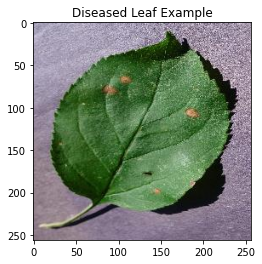

In [10]:
#Diseased leaf Image 
image_diseased = mpimg.imread("dataset/train/diseased/8.jpg")
plt.title("Diseased Leaf Example")
plt.imshow(image_diseased)


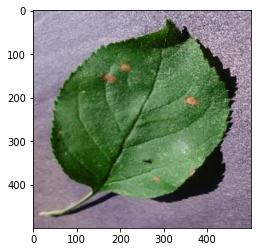

In [11]:
#Fixed Size Image
path = 'dataset/train/diseased/8.jpg'

image = mpimg.imread(path)
fixedsizeimage = cv2.resize(image, fixed_size)

plt.imshow(fixedsizeimage)



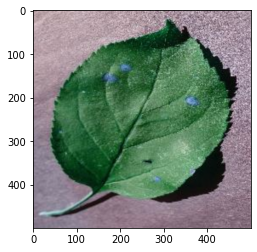

In [12]:
#RGB-BGR Conversion

rgbbgr=rgb_bgr(fixedsizeimage)

plt.imshow(rgbbgr)


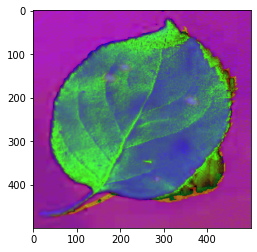

In [13]:
#BGR-HSV Conversion

bgrhsv=bgr_hsv(rgbbgr)
plt.imshow(bgrhsv)


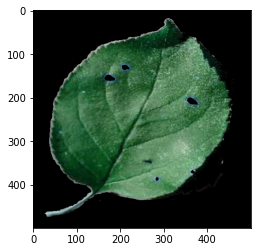

In [14]:
#Image Segmentation

segmentedimage=img_segmentation(rgbbgr,bgrhsv)
plt.imshow(segmentedimage)


## Color Histogram

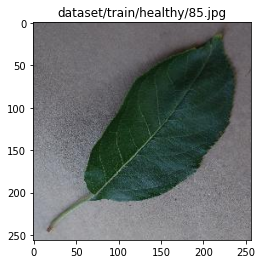

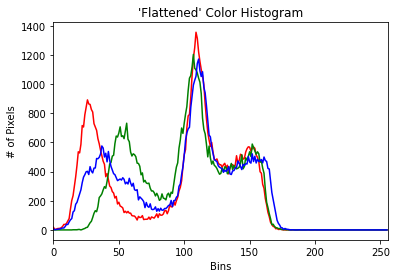

In [15]:
#fv_histogram  = fd_histogram(segmentedimage)
path_ = 'dataset/train/healthy/85.jpg'
#path_ = 'dataset/train/diseased/683.jpg'
plt.title(path_)
image_ = mpimg.imread(path_)

plt.imshow(image_)

colors=['r', 'g', 'b']
# split the image into its respective channels, then initialize the
chans = cv2.split(image_)

plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and plot it
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color=color)
	plt.xlim([0, 256])



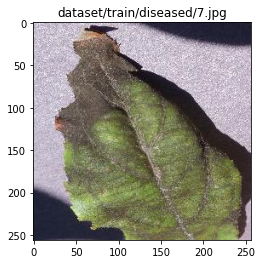

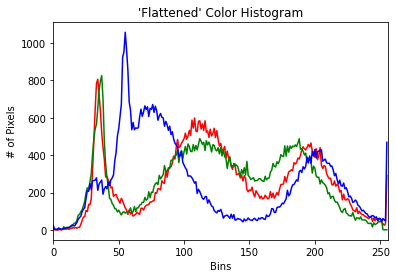

In [46]:
#fv_histogram  = fd_histogram(segmentedimage)
#path_ = 'dataset/train/healthy/85.jpg'
path_ = 'dataset/train/diseased/7.jpg'
plt.title(path_)
image_ = mpimg.imread(path_)

plt.imshow(image_)

colors=['r', 'g', 'b']
# split the image into its respective channels, then initialize the
chans = cv2.split(image_)

plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and plot it
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	plt.plot(hist, color=color)
	plt.xlim([0, 256])


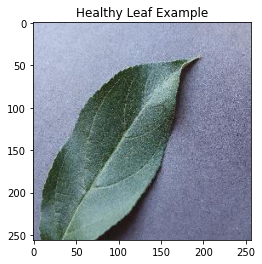

In [16]:
#Healthy Leaf Image
image_healthy = mpimg.imread("dataset/train/healthy/3.jpg")
plt.title("Healthy Leaf Example")
plt.imshow(image_healthy)

## Global feature Extraction

In [17]:
# loop over the training data sub-folders (Either Diseased or Healthy)
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Feature Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
    
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        
        
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


## Label Encoding the target and Scaling the features

In [18]:
# Encode The Target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("training labels encoded...!")

#Mapping of Target Labels (Diseased and Healthy)
le_name_mapping = dict(zip(targetNames,range(len(target))))

print(le_name_mapping)


training labels encoded...!
{'diseased': 0, 'healthy': 1}


In [19]:
# Scale features from global features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler # Could use Standard Scaler too!
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("feature vector normalized...")

feature vector normalized...


## Saving Data using HDF5 (Hierarchical Data Format version 5)

In [20]:
# Save the feature vectors using HDF5 
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1600, 532), type "<f8">

In [21]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))
h5f_data.close()

## Training ML Models 

In [22]:
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
#import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "dataset/train"
test_path  = "dataset/test"
h5_train_data    = 'dataset/output/train_data.h5'
h5_train_labels  = 'dataset/output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))


# import the feature vector and trained labels from h5f files
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("Features shape: {}".format(global_features.shape))
print("Labels shape: {}".format(global_labels.shape))

print("Training Started...")

Features shape: (1600, 532)
Labels shape: (1600,)
Training Started...


## Splitting the training and testing data

In [23]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (1280, 532)
Test data   : (320, 532)


In [24]:
trainDataGlobal

array([[0.9414392 , 0.        , 0.        , ..., 0.01058929, 0.12698813,
        0.96572853],
       [0.97289631, 0.01041268, 0.03357141, ..., 0.0105888 , 0.12692679,
        0.9657326 ],
       [0.91824532, 0.        , 0.25831096, ..., 0.01058952, 0.12718394,
        0.96573323],
       ...,
       [0.98950922, 0.05492806, 0.05534157, ..., 0.01058895, 0.12703792,
        0.96573215],
       [0.97183162, 0.01375817, 0.0063368 , ..., 0.01058889, 0.12695256,
        0.9657322 ],
       [0.91785918, 0.10765317, 0.12473313, ..., 0.01058989, 0.1269411 ,
        0.96573248]])

In [25]:
#find mapping of test and train data to the file names

## Trained ML Algorithms Comparision

LR: 10 fold results :-
 [0.9296875 0.9296875 0.921875  0.921875  0.8984375 0.90625   0.9453125
 0.9453125 0.921875  0.9140625]
mean: 0.923438  (0.014321)


LDA: 10 fold results :-
 [0.90625   0.9453125 0.921875  0.9296875 0.9375    0.8984375 0.890625
 0.921875  0.9140625 0.875    ]
mean: 0.914062  (0.020670)


KNN: 10 fold results :-
 [0.9375    0.9453125 0.9453125 0.9453125 0.90625   0.90625   0.90625
 0.9453125 0.9296875 0.90625  ]
mean: 0.927344  (0.017832)


CART: 10 fold results :-
 [0.8984375 0.953125  0.9296875 0.8671875 0.8984375 0.921875  0.9609375
 0.9296875 0.8671875 0.9296875]
mean: 0.915625  (0.030619)


RF: 10 fold results :-
 [0.9453125 0.9921875 0.96875   0.953125  0.9453125 0.9609375 0.984375
 0.9609375 0.953125  0.9453125]
mean: 0.960938  (0.015625)


NB: 10 fold results :-
 [0.84375   0.890625  0.859375  0.890625  0.859375  0.84375   0.875
 0.828125  0.8359375 0.8515625]
mean: 0.857812  (0.020611)


SVM: 10 fold results :-
 [0.921875  0.9375    0.921875  0.921875  0.

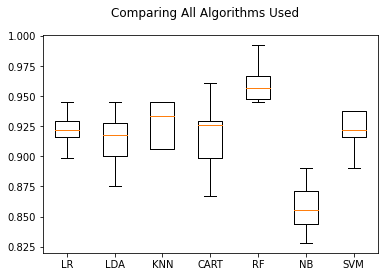

In [26]:
import matplotlib.pyplot as plt

# variables to hold the results and names
results = []
names   = []

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    print(name +': 10 fold results :-\n',cv_results )
    
    results.append(cv_results)
    
    names.append(name)
    msg = "%s: %f  (%f)" % ('mean', cv_results.mean(), cv_results.std())
    print(msg)
    print('\n')

# boxplot algorithm comparison
figure = plt.figure()
figure.suptitle('Comparing All Algorithms Used')
ax = figure.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Prediction Using Random Forest

In [27]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [28]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

In [29]:
y_predict=clf.predict(testDataGlobal)

In [30]:
#Array of actual labels
testLabelsGlobal

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,

In [31]:
# Number of actual diseased and Healthy plant leaves
y_actual=pd.Index(testLabelsGlobal)
y_actual.value_counts()

0    173
1    147
dtype: int64

In [32]:
#Array of predicted labels
y_predict

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,

In [33]:
# Number of predicted diseased and Healthy plant leaves
y=pd.Index(y_predict)
y.value_counts()

0    165
1    155
dtype: int64

In [34]:
#Incorrectly Predicted plants (With indexes)
print(np.where(y_predict != testLabelsGlobal))
x=np.where(y_predict != testLabelsGlobal)[0]
print('Unmatched',x.size)

(array([ 10,  56,  74,  80, 108, 121, 129, 135, 158, 160, 177, 189, 202,
       233, 260, 306], dtype=int64),)
Unmatched 16


In [35]:
#Table showing test labels and predicted labels for given test data of leaf images
import pandas as pd

df = pd.DataFrame({'Test':testLabelsGlobal, 'Predicted':y_predict})
df

,Test,Predicted
0,0,0
1,1,1
2,1,1
3,0,0
4,1,1
...,...,...
315,1,1
316,0,0
317,1,1
318,0,0


In [36]:
#Confusion Matrix
cf_matrix = confusion_matrix(testLabelsGlobal,y_predict)
cf_matrix


array([[161,  12],
       [  4, 143]], dtype=int64)

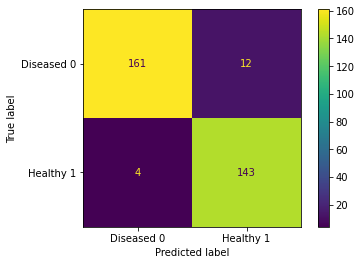

In [37]:
#Confusion Matrix Visualization

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(testLabelsGlobal, y_predict)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Diseased 0','Healthy 1'])
cmd.plot()


In [38]:
accuracy_score(testLabelsGlobal, y_predict)

0.95

In [39]:

# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics

# #Create KNN Classifier
# for i in range(1,10):
#     knn = KNeighborsClassifier(n_neighbors=i)

#     #Train the model using the training sets
#     knn.fit(trainDataGlobal, trainLabelsGlobal)

#     #Predict the response for test dataset
#     y_pred_knn = knn.predict(testLabelsGlobal)

#     # Model Accuracy, on the same

#     print("k=",i, ": Accuracy:",metrics.accuracy_score(testLabelsGlobal, y_pred_knn))

## Effect of Varying Random Forest hyperparameters

1. Sample size vs Accuracy 

>0.1 0.927 (0.023)
>0.2 0.938 (0.024)
>0.3 0.946 (0.019)
>0.4 0.949 (0.020)
>0.5 0.954 (0.019)
>0.6 0.958 (0.017)
>0.7 0.960 (0.018)
>0.8 0.962 (0.016)
>0.9 0.962 (0.015)
>1.0 0.960 (0.017)


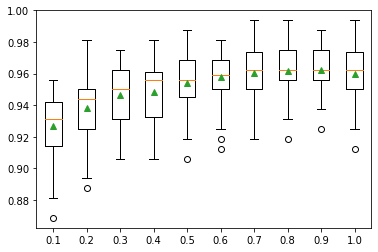

In [40]:
# explore random forest bootstrap sample size on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

X=global_features
y=labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

2. Number of Trees vs Accuracy

>10 0.950 (0.019)
>50 0.959 (0.018)
>100 0.964 (0.016)
>500 0.965 (0.017)
>1000 0.965 (0.016)


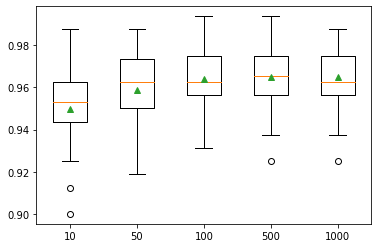

In [41]:
# explore random forest number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
 

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = RandomForestClassifier(n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
X=global_features
y=labels
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Hybrid PSO-Random Forest Implementation

PSO Functions

In [48]:

# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    num_trees=opts['num_trees']
    seeds=['seeds']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    #mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost



def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    

def pso(xtrain, ytrain, opts):
    # Default Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
  
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    #Stopping Criteria
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        Gbin2       = binary_conversion(Xgb, thres, 1, dim) 
        Gbin2       = Gbin2.reshape(dim)
        pos2        = np.asarray(range(0, dim))
        sel_index2  = pos2[Gbin2 == 1]
        
       
        print("Feature Subset after {} iterations {}: ".format(t+1,sel_index2))
        
        # Store result
        curve[0,t] = fitG.copy()
        
        print("Iteration:", t + 1)
        
        print("Best (PSO):", curve[0,t])
        t += 1
        
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
           
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data    

Feature Subset after 1 iterations [  0   2   5   6   7   8  10  11  12  14  15  16  17  19  23  28  31  33
  34  35  36  37  42  43  46  48  51  56  57  63  64  65  66  68  70  73
  75  78  82  84  85  90  91  92  93  96 100 101 104 107 109 110 111 114
 118 120 123 124 128 129 130 131 133 135 139 140 146 147 149 151 152 157
 165 166 168 170 173 175 176 179 180 182 186 188 190 193 196 198 199 202
 203 206 208 209 214 215 216 217 218 220 221 222 224 225 227 228 229 230
 232 234 237 238 240 241 242 243 246 250 251 254 255 257 259 260 262 264
 268 270 271 273 275 277 280 281 283 288 292 293 294 295 296 297 300 301
 302 304 306 310 313 314 315 316 318 320 323 324 327 331 332 334 335 337
 338 339 341 343 345 352 353 355 356 357 358 360 365 367 368 372 375 376
 378 379 380 384 385 388 390 391 394 399 401 402 403 405 406 407 408 410
 411 412 413 414 415 417 419 421 423 425 426 432 434 436 437 438 443 445
 448 449 450 453 454 455 457 459 461 462 466 468 469 471 473 476 478 479
 480 481 482 484 

Feature Subset after 9 iterations [  0   2   5   6   8  14  15  16  19  20  23  27  28  31  33  34  35  36
  41  42  43  46  51  53  56  57  63  64  65  66  68  70  73  74  75  80
  82  84  86  90  92  93  97 100 101 104 107 109 110 111 112 114 115 119
 120 123 124 126 128 129 130 133 135 139 140 146 147 149 150 151 156 157
 158 170 173 174 175 176 180 182 188 190 191 196 198 199 200 202 203 205
 206 209 213 214 216 217 218 221 222 223 224 225 227 228 230 232 233 234
 237 238 239 240 241 242 243 244 246 248 250 254 255 257 258 259 260 262
 264 270 271 273 275 277 280 281 282 283 288 293 294 295 296 297 299 300
 305 306 309 311 312 314 315 316 320 323 324 327 331 332 335 338 339 340
 341 343 345 349 352 353 355 356 357 359 360 362 366 372 373 376 378 379
 380 381 382 383 385 388 391 394 401 403 405 407 408 411 412 413 414 415
 417 419 422 423 425 426 432 436 437 442 443 445 446 448 449 450 452 455
 459 461 462 468 471 473 476 478 479 480 482 484 486 487 489 490 493 495
 496 498 499 500 

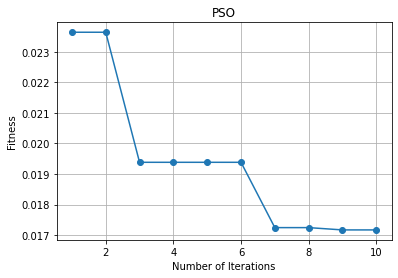

In [49]:
gasf=global_features

label=global_labels

# split data into train & validation (70 -- 30)
xtrain, xtest, ytrain, ytest = train_test_split(gasf, label, test_size=0.3, random_state=0, stratify=label)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# # parameter
# k    = 5     # k-value in KNN
# N    = 10    # number of particles
# T    = 100   # maximum number of iterations
# w    = 0.9   # inertia weight
# c1   = 2     # cognitive factor
# c2   = 2     # social factor 

# parameter
k    = 8     # k-value in KNN
num_trees=100  #random forest
seeds=9       #rf
N    = 15    # number of particles
T    = 10   # maximum number of iterations
w    = 0.5   # inertia weight
c1   = 2     # cognitive factor
c2   = 2     # social factor 
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2, 'num_trees':num_trees, 'seeds':seeds}

# perform feature selection
fmdl = pso(gasf, label, opts)
sf   = fmdl['sf']
print("fmdl",fmdl);

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train) 
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  

#Modelling using KNN
#mdl       = KNeighborsClassifier(n_neighbors = k) 

#Modelling using Random Forest
mdl  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
mdl.fit(x_train, y_train)

# Accuracy
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
print("Accuracy:", 100 * Acc)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)
n_sf=[]
print(sf)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()